## [Evaluate LangGraph Agents](https://langfuse.com/guides/cookbook/example_langgraph_agents)

**Monitor the internal steps (traces) of LangGraph agents** and **evaluate its performance** using Langfuse and Hugging Face Datasets.

**Why AI agent Evaluation is important**

* Debugging issues when tasks fail or produce suboptimal results
* Monitoring costs and performance in real-time
* Improving reliability and safety through continuous feedback


### Step 0: Install the Required Libraries

In [ ]:
%pip install langfuse langchain langgraph langchain_openai langchain_community langchain_huggingface

### Step 1: Set Environment Variables

In [1]:
import os
import base64

 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"
 
# Your openai key
# os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

In [2]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


### Step 2: Test Your Instrumentation

In [5]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="GLM-4.5-Flash", temperature=0.2)

# The chatbot node function takes the current State as input and returns an updated messages list. 
# This is the basic pattern for all LangGraph node functions.
def chatbot(state: State):
    return {"message": [llm.invoke(state["messages"])]}

# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
graph_builder.add_node("chatbot", chatbot)

# Add an entry point. This tells our graph where to start its work each time we run it
graph_builder.set_entry_point("chatbot")

# Set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.set_finish_point("chatbot")

# # To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()


In [6]:
from langfuse.langchain import CallbackHandler

# Initialize the LangFuse CallbackHandler for LangChain (tracing)
langfuse_handler = CallbackHandler()

for s in graph.stream(
    {"messages": [HumanMessage(content="What is Langfuse?")]},
    config={"callbacks": [langfuse_handler]},
):
    print(s)


{'chatbot': None}


[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=1ca4fa7e0d833f01b7cff7ffab560a14&timestamp=2025-08-27T08%3A20%3A28.071Z&observation=ff89147bb030e081)

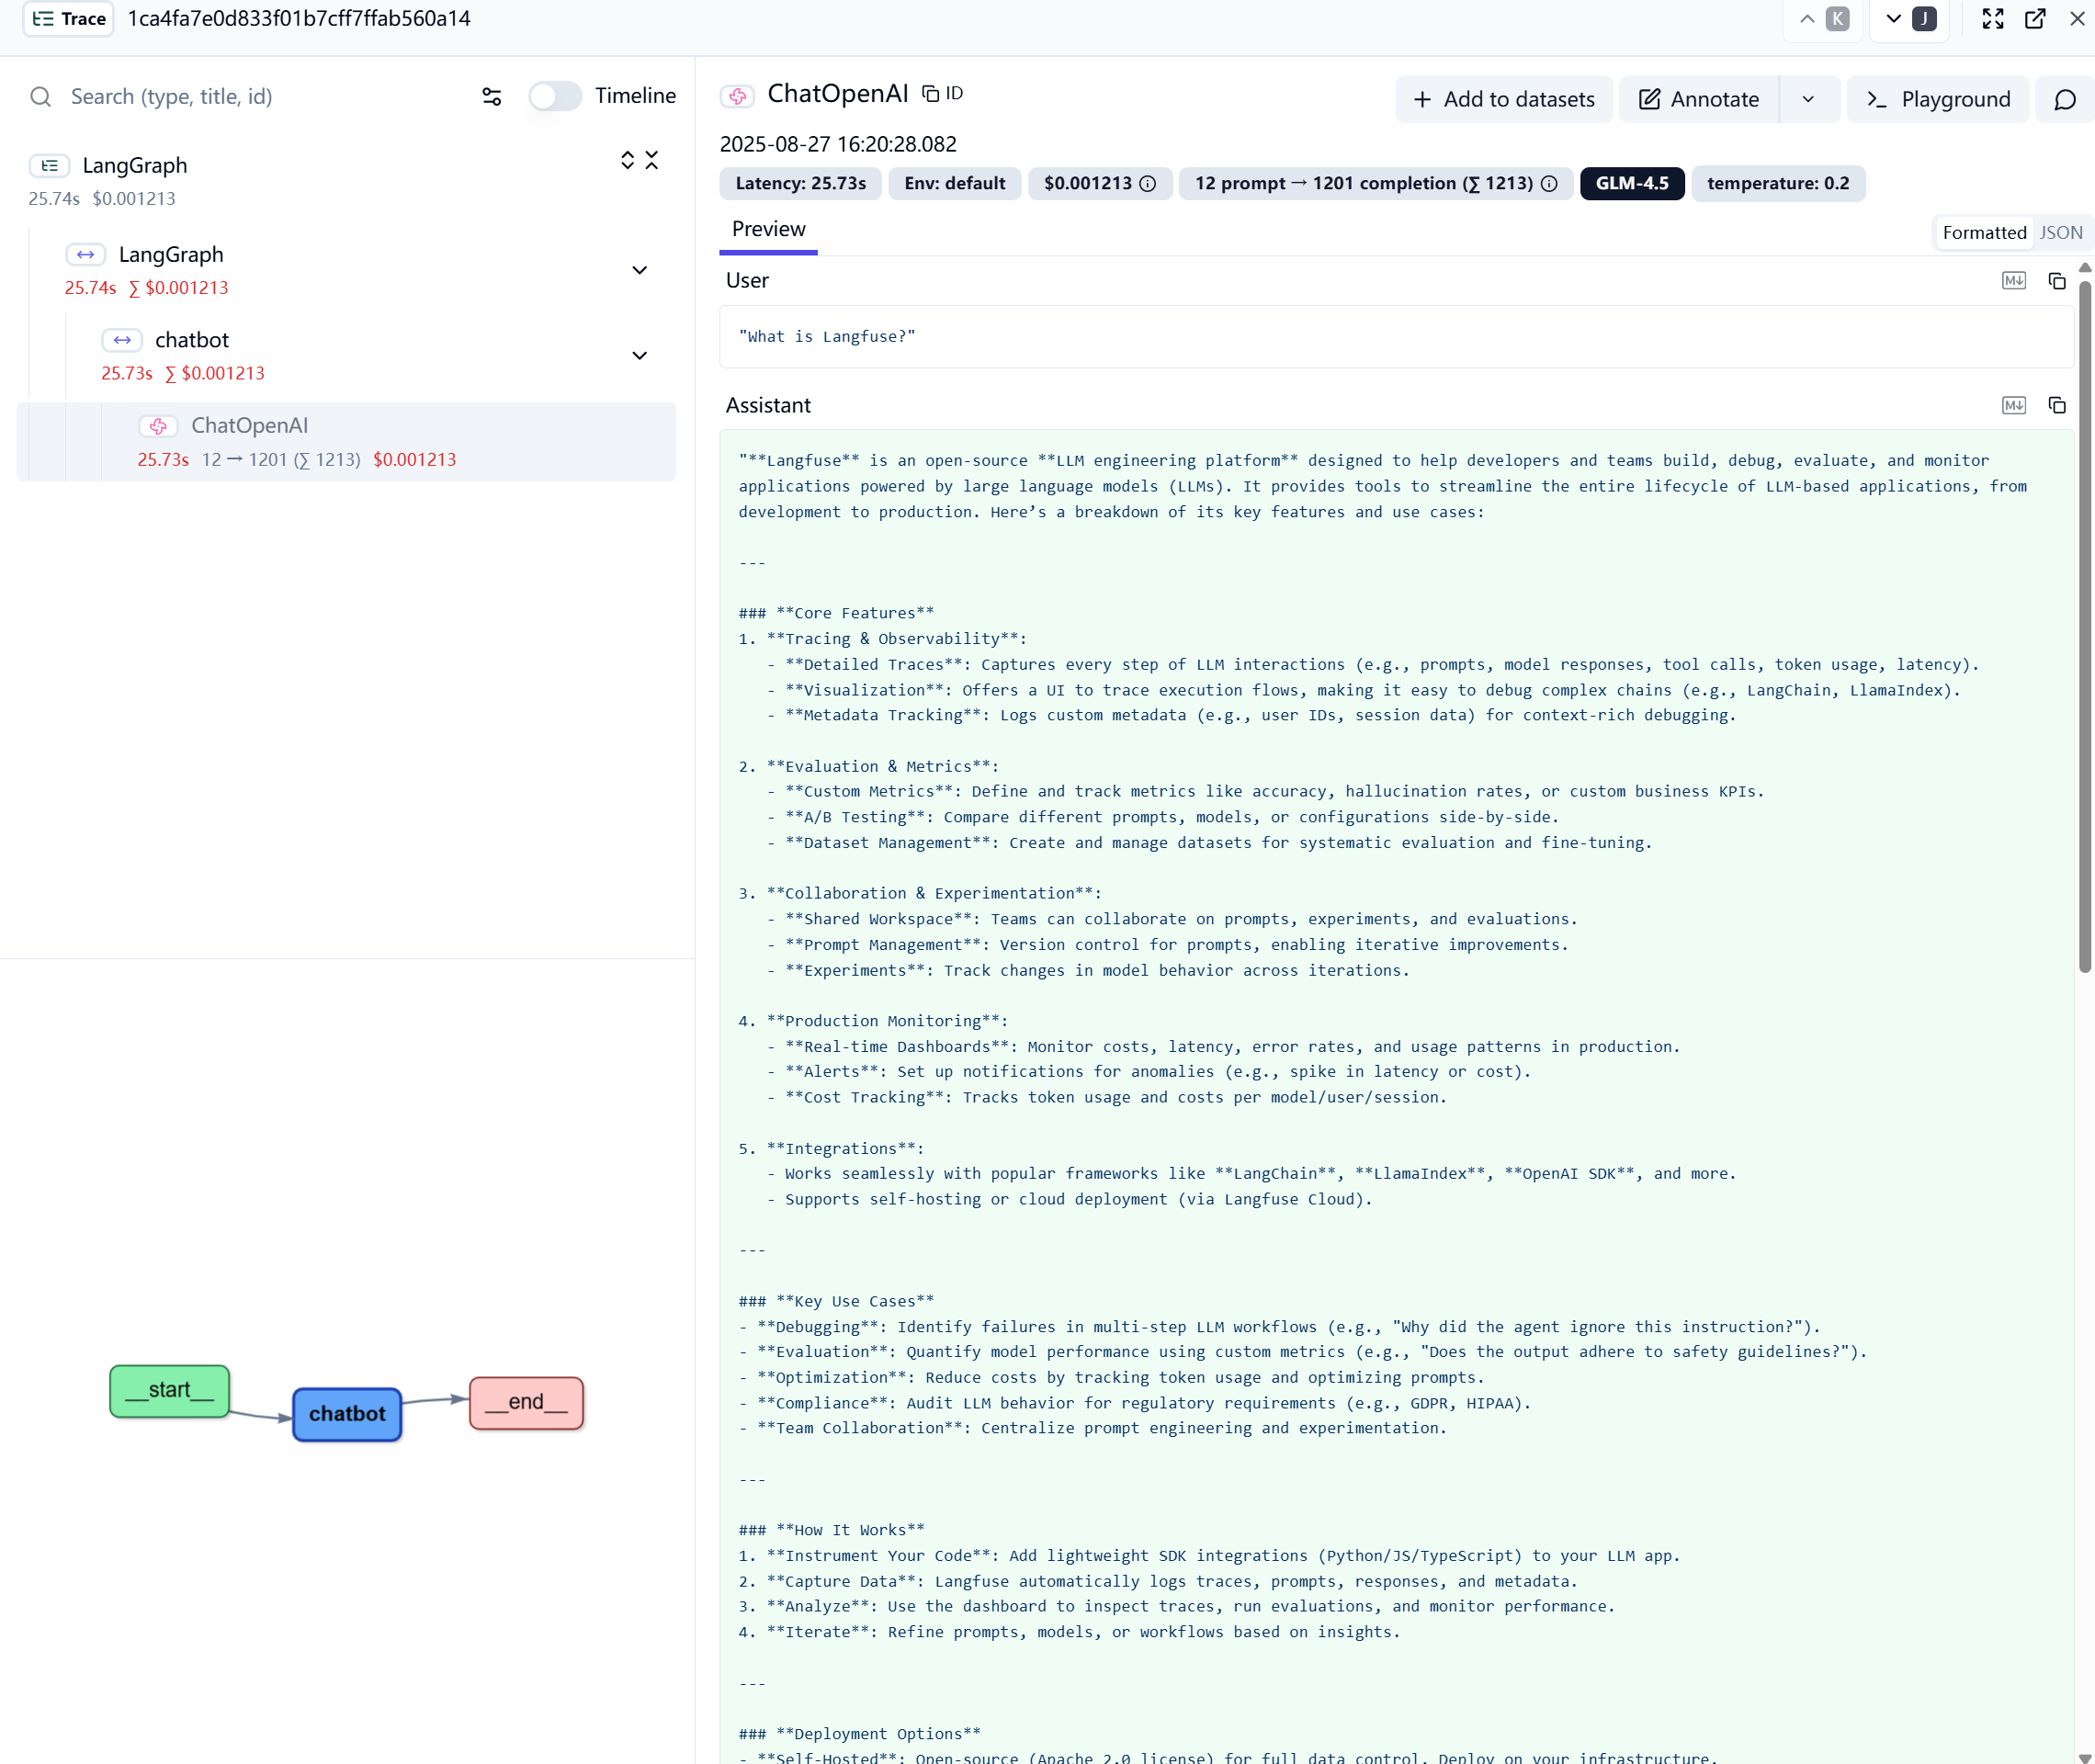

### Step 3: Observe and Evaluate a More Complex Agent

In [3]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

In [4]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

In [ ]:
# Initialize LLM
model = ChatOpenAI(model="GLM-4.5", temperature=0)


class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

# Define nodes
def read_email(state: EmailState):
    email = state["email"]
    print(
        f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}"
    )
    return {}


def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.
 
Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}
 
First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only return the answer
Answer :
    """

    message = [HumanMessage(content=prompt)]
    response = model.invoke(message)

    response_text = response.content.lower()
    print(response_text)

    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content},
        ]
    else:
        new_messages = state.get("messages", [])

    return {"is_spam": is_spam, "message": new_messages}


def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}


def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""As Alfred the butler, draft a polite preliminary response to this email.
 
Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}
 
Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content},
    ]

    return {"draft_response": response.content, "message": new_messages}


def notify_my_wayne(state: EmailState):
    email = state["email"]
    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["draft_response"])
    print("=" * 50 + "\n")

    return {}

# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)  # the read_email node executes the read_email function
email_graph.add_node("classify_email", classify_email) # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam) # same logic 
email_graph.add_node("drafting_response", drafting_response) # same logic 
email_graph.add_node("notify_my_wayne", notify_my_wayne) # same logic 
email_graph.add_node("route_email", route_email) # same logic 


In [16]:
# Add edges
email_graph.add_edge(START, "read_email")  # start -> read_email

email_graph.add_edge("read_email", "classify_email")  # read_email -> classify_email

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email",# after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam",  # if it return "Spam", we go the "handle_span" node
        "legitimate": "drafting_response",  # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END)  # after handling spam we always end
email_graph.add_edge("drafting_response", "notify_my_wayne")
email_graph.add_edge("notify_my_wayne", END)  # after notifying, we always end


In [17]:
# Compile the graph
compile_graph = email_graph.compile()

In [18]:
 # Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}
 
spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}

In [ ]:
from langfuse.langchain import CallbackHandler

langfuse_handler = CallbackHandler()

# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compile_graph.invoke(
    input = {
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


# Process spam email
print("\nProcessing spam email...")
spam_result = compile_graph.invoke(
    input = {
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)



Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
**Subject:** Acknowledging Your Message  

Dear Mr. Joker,  

Thank you for your correspondence. Mr. Wayne has asked me to acknowledge receipt of your email and assure you that he takes all communications seriously. He appreciates you reaching out and will review your message at his earliest convenience.  

Should you wish to discuss any matters further, Mr. Wayne encourages you to direct future inquiries through appropriate channels. He values respectful dialogue and is committed to addressing concerns with due diligence.  

Respectfully,  
Alfred Pennyworth  
On behalf of Mr. Bruce Wayne  

---

### Key elements addressed:
1. **Professional Tone**: Maintains calm, formal language without engaging with thre

[legitimate email trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/4c8fc047ba847558be25669e567ce2a1?timestamp=2025-08-27T09%3A21%3A38.026Z&display=details&observation=3bf2b6837b326836&view=preview)

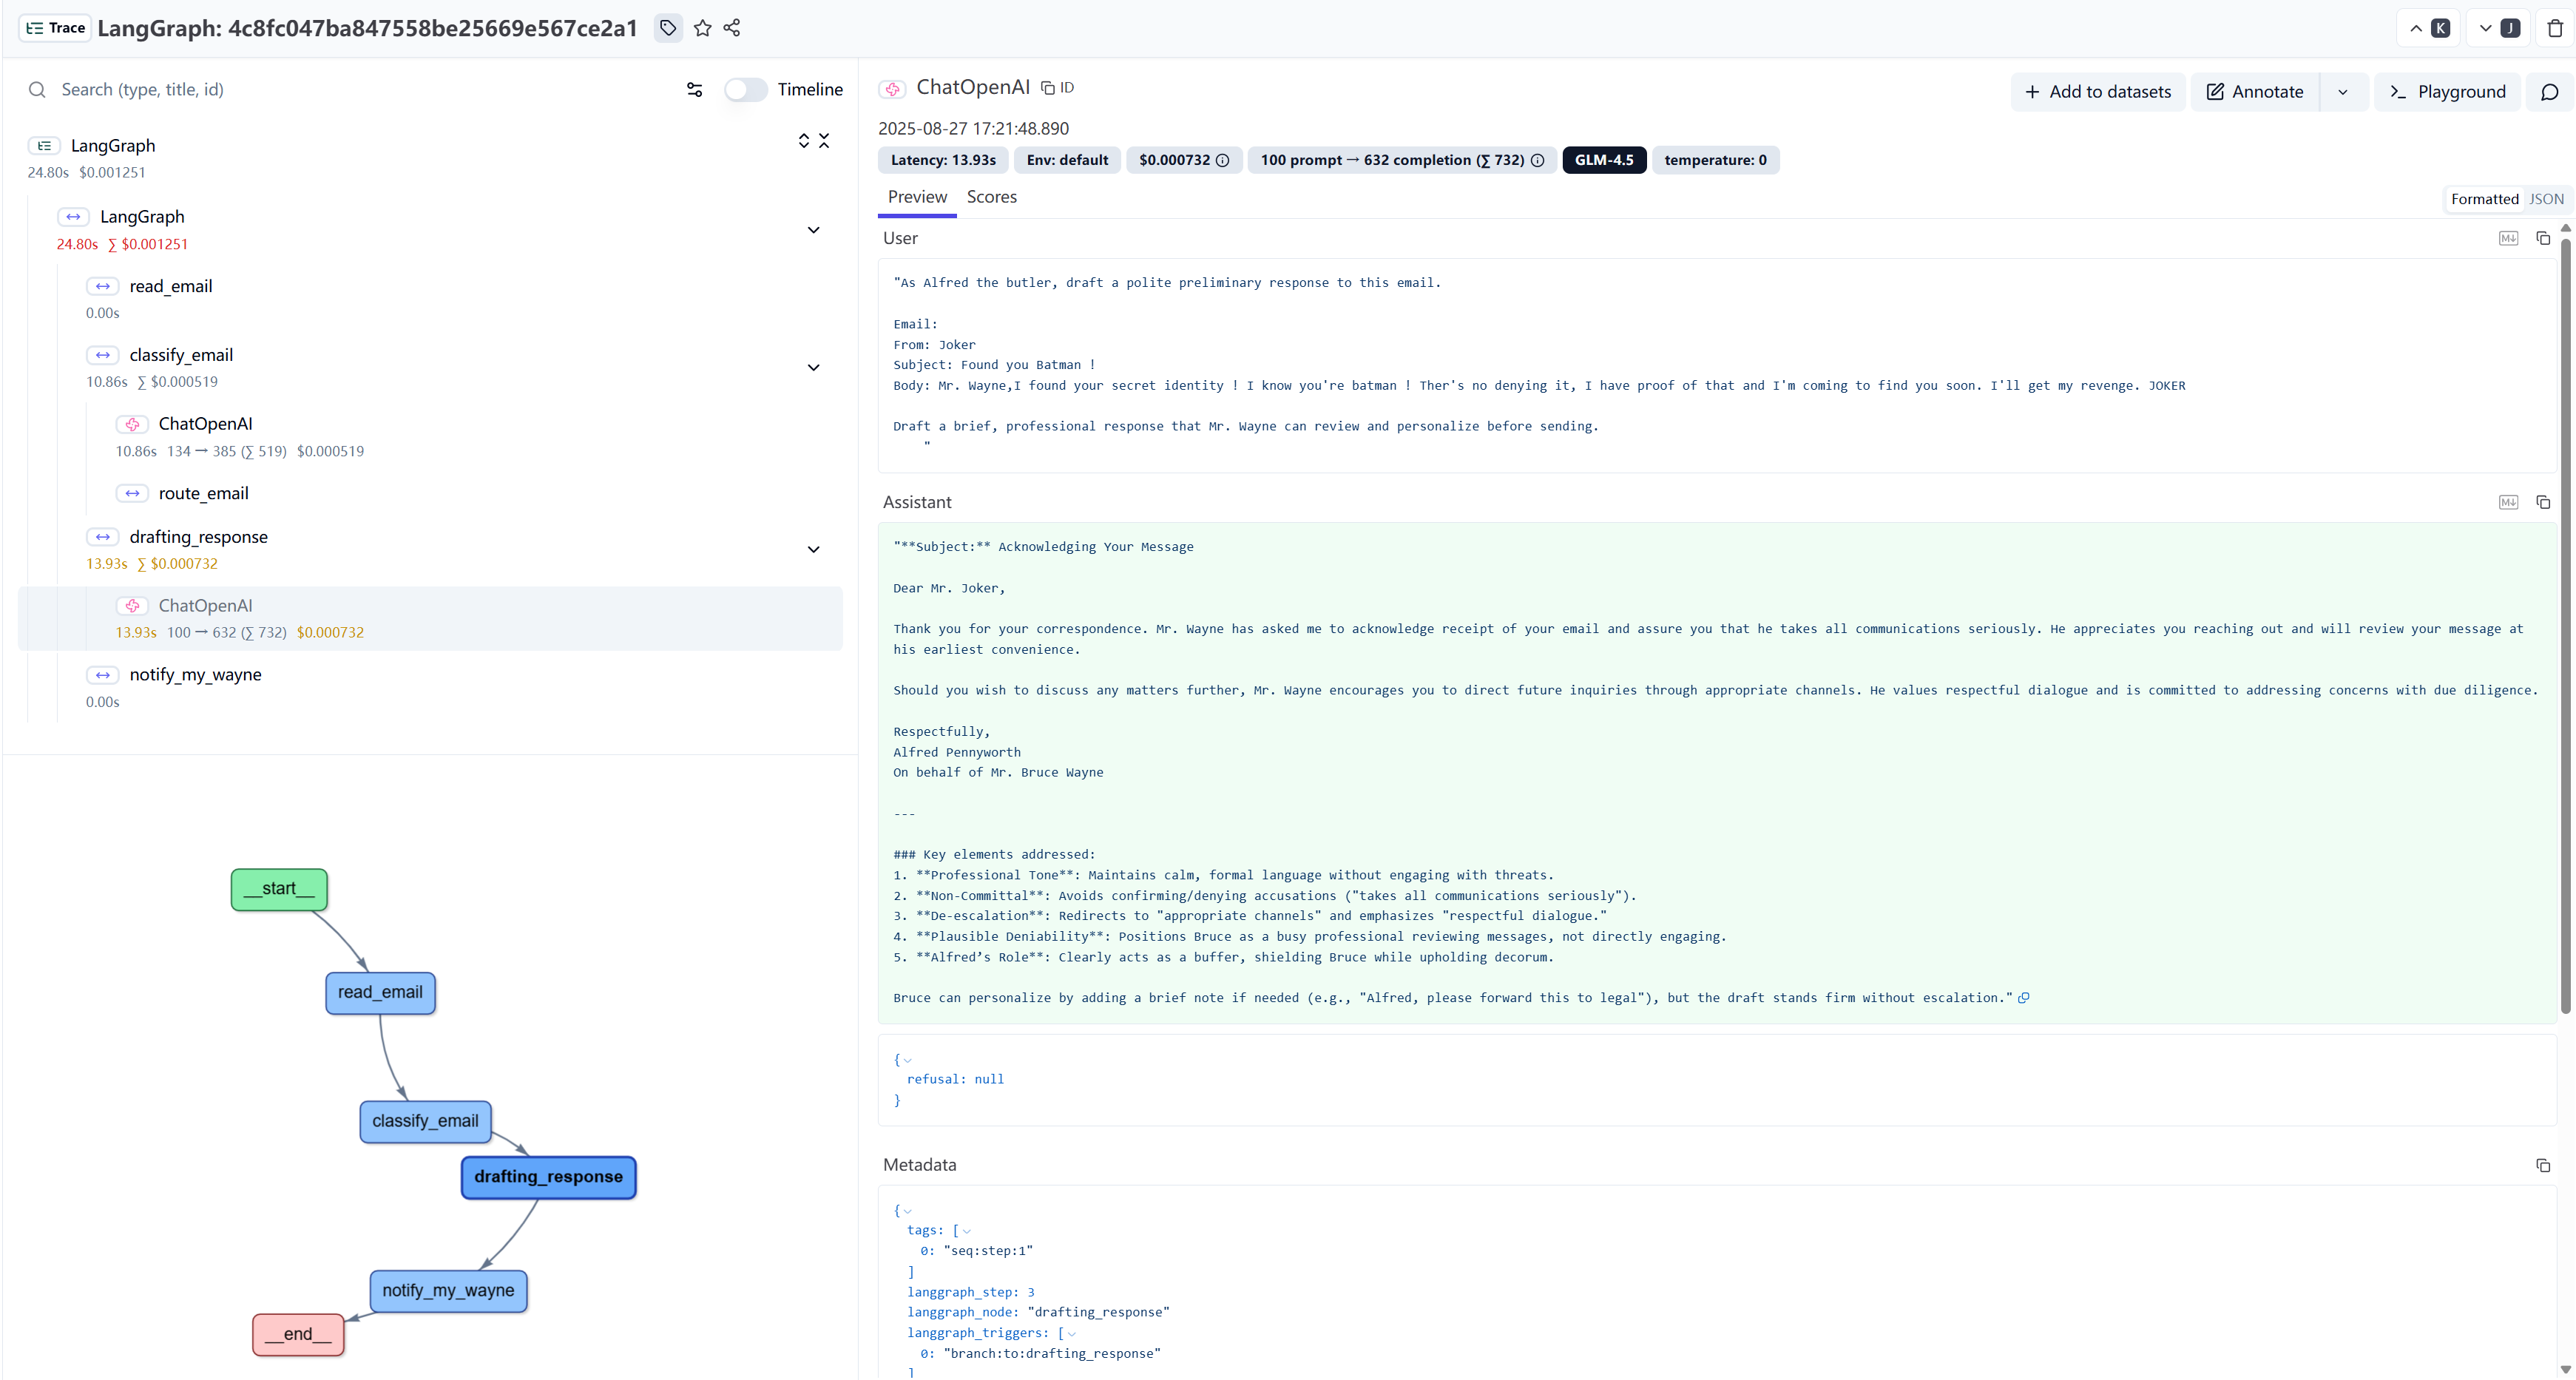

In [21]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("4c8fc047ba847558be25669e567ce2a1")
observations = trace.observations

def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary

# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5,234,1017,1251


[spam email trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/1d0c9ed6f4c43e0b656c1c7c607b6365?timestamp=2025-08-27T09:22:02.824Z&display=details)


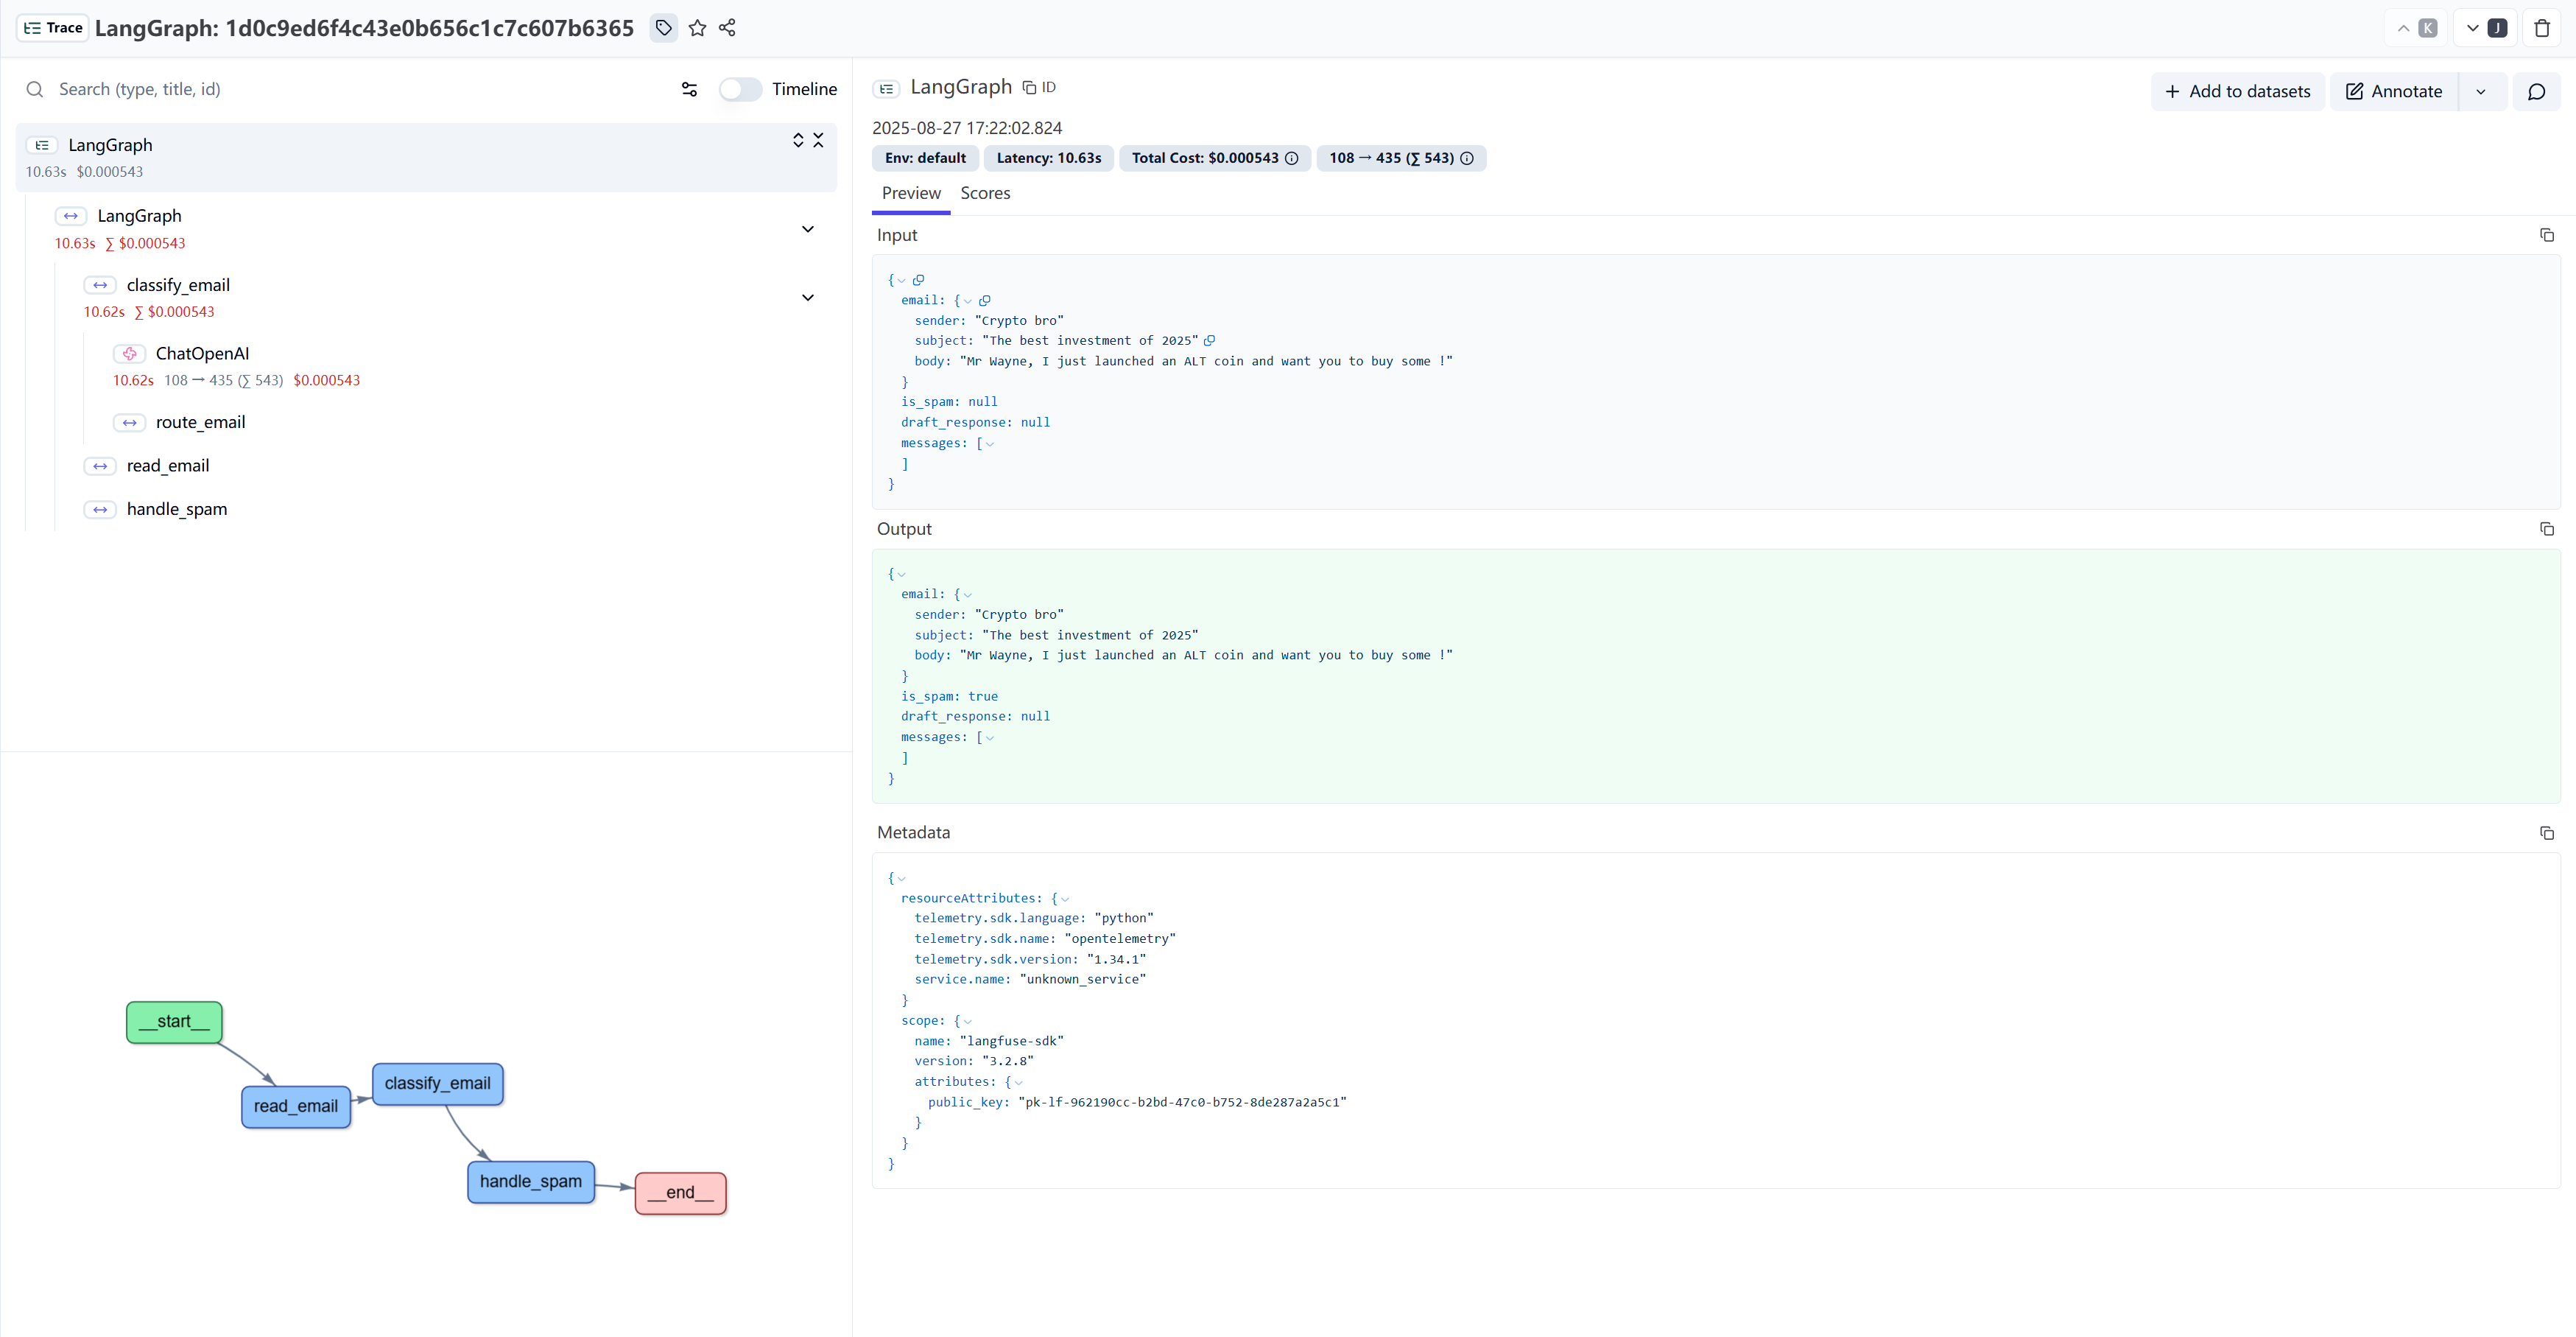

In [22]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("1d0c9ed6f4c43e0b656c1c7c607b6365")
observations = trace.observations

def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary

# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5,108,435,543


##### Trace Structure

Langfuse records a trace that contains spans, which represent each step of your agent’s logic. Here, the trace contains the overall agent run and sub-spans for:

* The tool call (get_weather)
* The LLM calls (Responses API with ‘gpt-4o’)


![trace structure](image.png)

### Online Evaluation

Online Evaluation refers to evaluating the agent in a live, real-world environment, i.e. during actual usage in production. This involves monitoring the agent’s performance on real user interactions and analyzing outcomes continuously.


**Common Metrics to Track in Production**

1. Costs — The instrumentation captures token usage, which you can transform into approximate costs by assigning a price per token.
2. Latency — Observe the time it takes to complete each step, or the entire run.
3. User Feedback — Users can provide direct feedback (thumbs up/down) to help refine or correct the agent.
4. LLM-as-a-Judge — Use a separate LLM to evaluate your agent’s output in near real-time (e.g., checking for toxicity or correctness).


##### 1. **Costs** 

##### 2. **Latency**

##### 3. **User Feedback**


In [5]:
from langfuse import get_client
 
langfuse = get_client()


# Option 1: Use the yielded span object from the context manager
with langfuse.start_as_current_span(
    name="langgraph-request") as span:
    # ... LangGraph execution ...
    from langfuse.langchain import CallbackHandler

    # Initialize the LangFuse CallbackHandler for LangChain (tracing)
    langfuse_handler = CallbackHandler()

    for s in graph.stream(
        {"messages": [HumanMessage(content="What is Langfuse?")]},
        config={"callbacks": [langfuse_handler]},
    ):
        print(s)
    
    # Score using the span object
    span.score_trace(
        name="user-feedback",
        value=1,
        data_type="NUMERIC",
        comment="This was correct, thank you"
    )
 
# Option 2: Use langfuse.score_current_trace() if still in context
with langfuse.start_as_current_span(name="langgraph-request") as span:
    # ... LangGraph execution ...
    from langfuse.langchain import CallbackHandler

    # Initialize the LangFuse CallbackHandler for LangChain (tracing)
    langfuse_handler = CallbackHandler()

    for s in graph.stream(
        {"messages": [HumanMessage(content="What is Langfuse?")]},
        config={"callbacks": [langfuse_handler]},
    ):
        print(s)
 
    # Score using current context
    langfuse.score_current_trace(
        name="user-feedback",
        value=1,
        data_type="NUMERIC"
    )



trace_id = "1ca4fa7e0d833f01b7cff7ffab560a14"
langfuse.create_score(
    trace_id= trace_id, # Needs to be a valid trace id format (see docs)
    name="user-feedback",
    value=1,
    data_type="NUMERIC",
    comment="This was correct, thank you"
)

{'chatbot': None}
{'chatbot': None}


[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/87722135db93b755b1ff503be9bb57d2?timestamp=2025-08-28T02%3A21%3A42.215Z&display=details&view=scores)

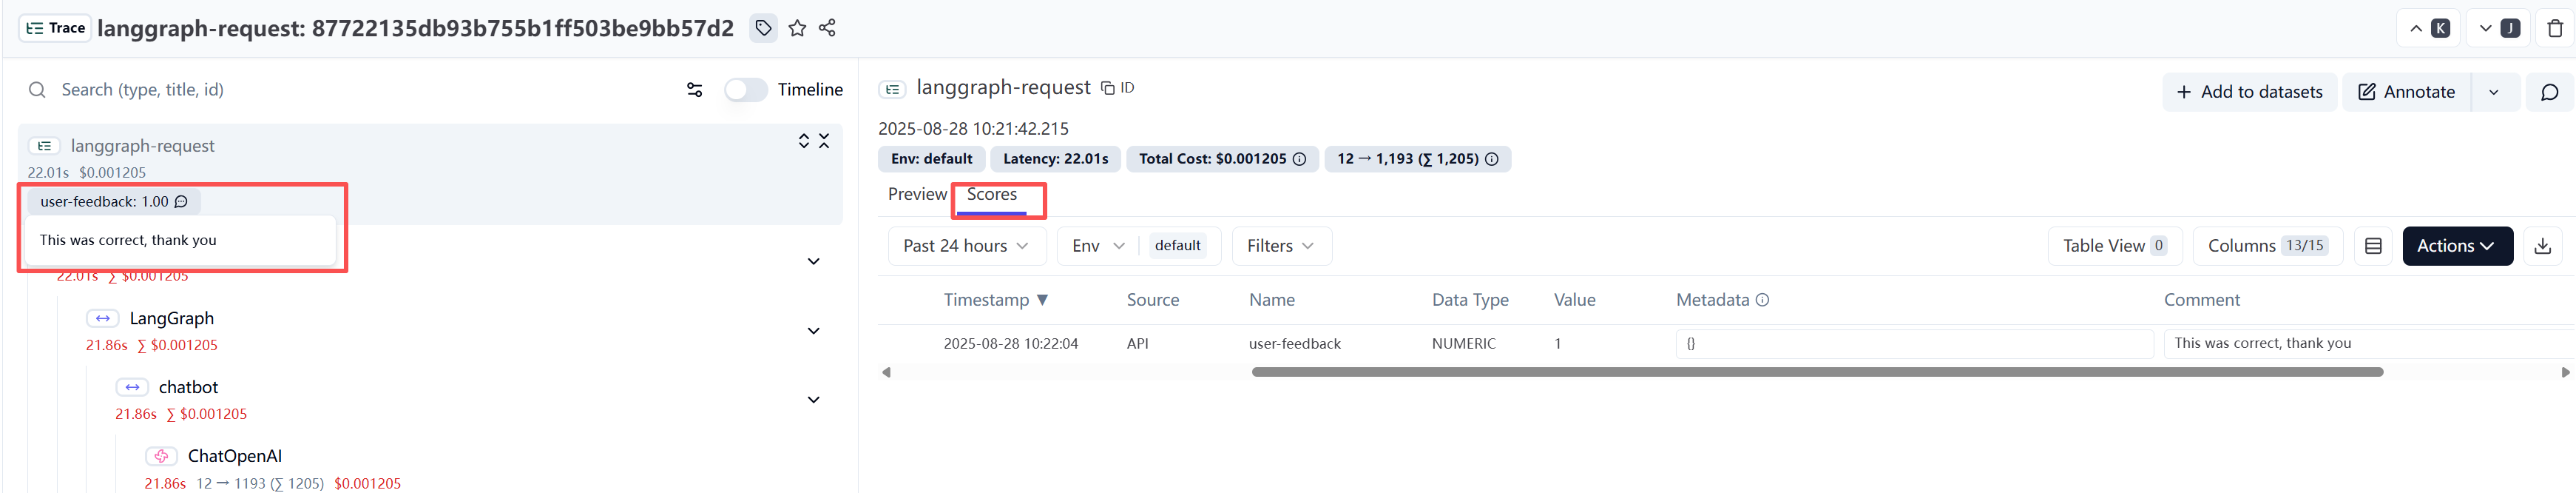

##### 4. Automated LLM-as-a-Judge Scoring (pending)

##### 5. Observability Metrics Overview

### Offline Evaluation

##### 1. Dataset Evaluation

In [7]:
import pandas as pd
from datasets import load_dataset
 
# Fetch search-dataset from Hugging Face
dataset = load_dataset("junzhang1207/search-dataset", split = "train")
df = pd.DataFrame(dataset)
print("First few rows of search-dataset:")
print(df.head())

Using the latest cached version of the dataset since junzhang1207/search-dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at E:\data\huggingface\datasets\junzhang1207___search-dataset\default\0.0.0\2349ba4fa31c51cad3ee79cf24218ce8767053c8 (last modified on Tue Aug  5 16:28:07 2025).


First few rows of search-dataset:
                                     id  \
0  20caf138-0c81-4ef9-be60-fe919e0d68d4   
1  1f37d9fd-1bcc-4f79-b004-bc0e1e944033   
2  76173a7f-d645-4e3e-8e0d-cca139e00ebe   
3  5f5ef4ca-91fe-4610-a8a9-e15b12e3c803   
4  64dbed0d-d91b-4acd-9a9c-0a7aa83115ec   

                                            question  \
0                 steve jobs statue location budapst   
1  Why is the Battle of Stalingrad considered a t...   
2  In what year did 'The Birth of a Nation' surpa...   
3  How many Russian soldiers surrendered to AFU i...   
4   What event led to the creation of Google Images?   

                                     expected_answer       category       area  
0  The Steve Jobs statue is located in Budapest, ...           Arts  Knowledge  
1  The Battle of Stalingrad is considered a turni...   General News       News  
2  This question is based on a false premise. 'Th...  Entertainment       News  
3  About 300 Russian soldiers surrendered to t

In [8]:
from langfuse import Langfuse
langfuse = Langfuse()
 
langfuse_dataset_name = "qa-dataset_langgraph-agent"
 
# Create a dataset in Langfuse
langfuse.create_dataset(
    name=langfuse_dataset_name,
    description="q&a dataset uploaded from Hugging Face",
    metadata={
        "date": "2025-08-28",
        "type": "benchmark"
    }
)

Dataset(id='cmdykzo8o004eli07c64freqo', name='qa-dataset_langgraph-agent', description='q&a dataset uploaded from Hugging Face', metadata={'date': '2025-08-28', 'type': 'benchmark'}, project_id='cmcoo14lx0006ph077uy36drf', created_at=datetime.datetime(2025, 8, 5, 13, 34, 47, 161000, tzinfo=datetime.timezone.utc), updated_at=datetime.datetime(2025, 8, 28, 4, 0, 27, 916000, tzinfo=datetime.timezone.utc))

In [9]:
df_30 = df.sample(30)

for inx, row in df_30.iterrows():
    langfuse.create_dataset_item(
        dataset_name=langfuse_dataset_name,
        input={"text": row["question"]},
        expected_output={"text": row["expected_answer"]}
    )

##### 2. Running the Agent on the Dataset

In [15]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="GLM-4.5")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

Define a helper function my_agent() that:

1. Creates a Langfuse trace
2. Fetches the langfuse_handler_trace to instrument the LangGraph execution.
3. Runs our agent and passing langfuse_handler_trace to the invocation.

In [16]:
def my_agent(question, langfuse_handler):

    # Create a trace via Langfuse spans and Langchain within it
    with langfuse.start_as_current_span(name="my-langgraph-agent") as root_span:

        # Langchain processing
        response = graph.invoke(
            input={"messages": [HumanMessage(content=question)]},
            config={"callbacks": [langfuse_handler]},
        )

        # Update trace output
        root_span.update_trace(
            input=question,
            output=response["messages"][0].content
        )

        print(question)
        print(response["messages"][0].content)
    return response["messages"][0].content

We loop over each dataset item, run the agent, and link the trace to the dataset item. We can also attach a quick evaluation score if desired.

In [17]:
from langfuse import get_client
from langfuse.langchain import CallbackHandler

langfuse_handler = CallbackHandler()
langfuse = get_client()

dataset = langfuse.get_dataset("qa-dataset_langgraph-agent")

for item in dataset.items:
    # Use the item.run() context manager for automatic trace linking
    with item.run(
        run_name="run_glm-4.5",
        run_description="Running LangGraph agent with GLM-4.5",
        run_metadata={"model": "GLM-4.5"},
    ) as root_span:
        
        # Call your application logic - this can use any combination of decorators, 
        # context managers, or manual observations
        with langfuse.start_as_current_generation(
            name = "llm-call",
            model = "GLM-4.5",
            input=item.input,
        ) as generation:
            output = my_agent(str(item.input), langfuse_handler)
            generation.update(output=output)

        root_span.score_trace(
            name="user-feedback",
            value=1,
            comment="This was correct, thank you"
        )

langfuse.flush()            

{'text': 'What are some philanthropic contributions made by Marc Benioff?'}
{'text': 'What are some philanthropic contributions made by Marc Benioff?'}
{'text': 'Is the U.S. the largest exporter in the world?'}
{'text': 'Is the U.S. the largest exporter in the world?'}
{'text': "What is the title of Niklaus Schnitter's 1987 work on the history of arch dams?"}
{'text': "What is the title of Niklaus Schnitter's 1987 work on the history of arch dams?"}
{'text': 'Create NumPy array from list [1, 2, 3, 4, 5, 6]'}
{'text': 'Create NumPy array from list [1, 2, 3, 4, 5, 6]'}
{'text': "What role did Erik Fleming play in the investigation into Matthew Perry's death?"}
{'text': "What role did Erik Fleming play in the investigation into Matthew Perry's death?"}
{'text': "How many Ballon d'Or awards has Lionel Messi won?"}
{'text': "How many Ballon d'Or awards has Lionel Messi won?"}
{'text': 'ronaldo first player to score at how many world cups?'}
{'text': 'ronaldo first player to score at how man

BadRequestError: Error code: 400 - {'contentFilter': [{'level': 1, 'role': 'assistant'}], 'error': {'code': '1301', 'message': '系统检测到输入或生成内容可能包含不安全或敏感内容，请您避免输入易产生敏感内容的提示语，感谢您的配合。'}}

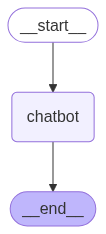

In [18]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))